In [1]:
! pip install googletrans stopwordsiso wordcloud

In [ ]:
import json

import pandas as pd

import scipy.stats as stats

from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data'
data = json.load(open(f'../{data_dir}/labelbox_sample_annotated.json'))
data.keys()

dict_keys(['d16ec044', '3fefb024'])

In [3]:
dfs = []
for annotator in data.keys():
    df_annotator = pd.DataFrame.from_records(data[annotator])
    df_annotator['annotator'] = annotator
    dfs.append(df_annotator)

df = pd.concat(dfs)
df["trigger_level"] = df["trigger_level"].astype(int)

In [4]:
df.columns

Index(['emotion', 'emotion_class', 'trigger_level', 'context',
       'context_locations', 'description', 'created_at', 'created_by', 'text',
       'id', 'annotator'],
      dtype='object')

In [5]:
df.head(2)

,emotion,emotion_class,trigger_level,context,context_locations,description,created_at,created_by,text,id,annotator
0,anger,negative,4,[США по разным каналам пытаются убедить своих ...,"[[300, 452]]",None,2024-05-03T09:23:42.000+00:00,d16ec044,"Путин: Те, кто планировали этот теракт, рассчи...",e19f77b7-f1a3-4f8a-b160-4af23deef647,d16ec044
1,undefined,positive,1,[],[],None,2024-05-03T09:32:28.000+00:00,d16ec044,«Чадыр-Лунга — город на семи холмах»: в Гагауз...,667ec738-34fe-4ced-b193-f97c47c4c9ce,d16ec044


In [6]:
df_d16ec044 = df[df.annotator == 'd16ec044'].sort_values(by='id')
df_3fefb024 = df[df.annotator == '3fefb024'].sort_values(by='id')
df_d16ec044.shape, df_3fefb024.shape

((236, 11), (236, 11))

In [7]:
def get_location_len(location):
    try:
        return location[1]-location[0]
    except:
        return None

df_d16ec044.explode('context_locations')['context_locations'].apply(get_location_len).mean()

47.621428571428574

In [8]:
df_3fefb024.explode('context_locations')['context_locations'].apply(get_location_len).mean()

18.590551181102363

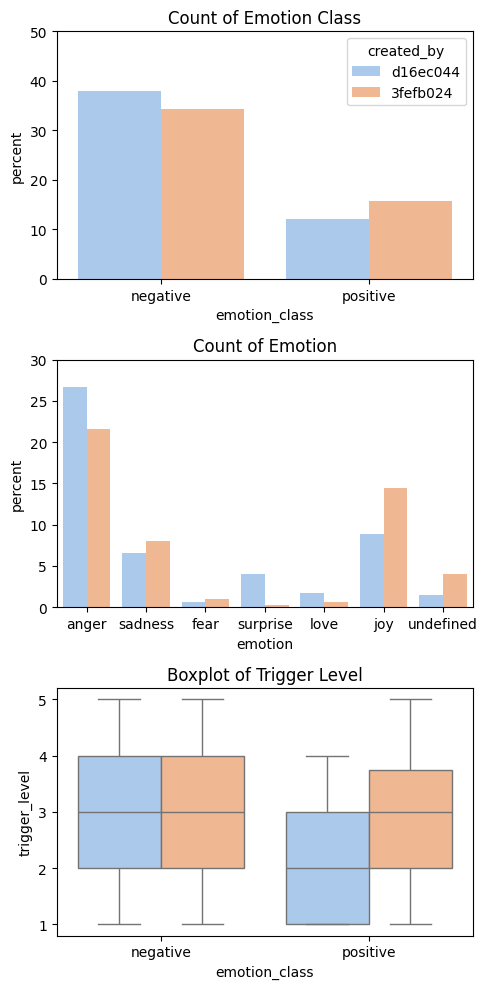

In [85]:
# Set up the matplotlib figure
plt.figure(figsize=(5, 10))

plt.subplot(3, 1, 1)
ax11 = sns.countplot(data=df, x='emotion_class', hue='created_by', order=["negative", "positive"], stat='percent', palette='pastel')
ax11.set_ylim(0, 50)
plt.title('Count of Emotion Class')

plt.subplot(3, 1, 2)
a12 = sns.countplot(data=df, x='emotion', hue='created_by',
                    order=["anger", "sadness", "fear", "surprise", "love", "joy", "undefined"], stat='percent', palette='pastel',
                   legend=False)
a12.set_ylim(0, 30)
plt.title('Count of Emotion')

plt.subplot(3, 1, 3)
a13 = sns.boxplot(data=df, y='trigger_level', x='emotion_class', hue='created_by', order=["negative", "positive"], palette='pastel',
                 legend=False)
# a13.set_ylim(0, 30)
plt.title('Boxplot of Trigger Level')

# Display the plots
plt.tight_layout()
plt.savefig('eda.png')
plt.show()

In [81]:
df.trigger_level.describe()

count    472.000000
mean       2.855932
std        1.178544
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: trigger_level, dtype: float64

In [10]:
### Categorical Variables: 'emotion' and 'emotion_class'
# Chi-Squared Test for 'emotion'
contingency_emotion = pd.crosstab(df_d16ec044['emotion'], df_3fefb024['emotion'])
_, p_emotion, _, _ = stats.chi2_contingency(contingency_emotion)

# Chi-Squared Test for 'emotion_class'
contingency_emotion_class = pd.crosstab(df_d16ec044['emotion_class'], df_3fefb024['emotion_class'])
_, p_emotion_class, _, _ = stats.chi2_contingency(contingency_emotion_class)

print()
print("Chi-Squared Test for Emotion:")
print("P-value =", p_emotion)

print("Chi-Squared Test for Emotion Class:")
print("P-value =", p_emotion_class)

print()
print("Normality Test for Trigger Level:")
_, p_value_1 = stats.normaltest(df_d16ec044['trigger_level'])
_, p_value_2 = stats.normaltest(df_3fefb024['trigger_level'])
print(f"Normality Test P-value For d16ec044 =", p_value_1)
print(f"Normality Test P-value For 3fefb024 =", p_value_2)

# Using Mann-Whitney U Test as a non-parametric alternative if normality is not assumed
u_stat, p_trigger = stats.mannwhitneyu(df_d16ec044['trigger_level'], df_3fefb024['trigger_level'], alternative='two-sided')

print("Mann-Whitney U Test for Trigger Level:")
print("P-value =", p_trigger)


Chi-Squared Test for Emotion:
P-value = 5.944718173448189e-09
Chi-Squared Test for Emotion Class:
P-value = 0.26886250893495856

Normality Test for Trigger Level:
Normality Test P-value For d16ec044 = 2.118182467941346e-08
Normality Test P-value For 3fefb024 = 0.00041765766574110617
Mann-Whitney U Test for Trigger Level:
P-value = 0.025205095567695023


In [11]:
n_stats, p_value = stats.normaltest(df_3fefb024['trigger_level'])
p_value

0.00041765766574110617

# Annotation agreement

In [12]:
cohen_kappa_score(df_d16ec044['emotion'], df_3fefb024['emotion'])

0.016131955773065032

In [13]:
cohen_kappa_score(df_d16ec044['emotion_class'], df_3fefb024['emotion_class'])

-0.08131672597864759

In [14]:
cohen_kappa_score(df_d16ec044['trigger_level'], df_3fefb024['trigger_level'])

0.12237261514297593

# Context evaluation

In [ ]:
def calc_span_intersection(true_context: list[tuple], predicted_context: list[tuple]):
    correct_pairs = []
    for true_start, true_end in true_context:
        true_chars = list(range(true_start, true_end + 1))
        for pred_start, pred_end in predicted_context:
            pred_chars = list(range(pred_start, pred_end + 1))
            intersection = sorted(set(true_chars).intersection(set(pred_chars)))
            if not intersection:
                continue
            correct_pairs.append((intersection[0], intersection[-1]))
    return correct_pairs

def calc_proportional_overlap(ann1_labels, ann2_labels):
    overlap_labels_total, overlap_labels_len = 0, 0
    ann1_labels_total, ann1_labels_len = 0, 0
    ann2_labels_total, ann2_labels_len = 0, 0
    overlaps_all = []
    for i, (ann1_labels_i, ann2_labels_i) in enumerate(zip(ann1_labels, ann2_labels)):
        ann1_labels_len += sum([e - s + 1 for s, e in ann1_labels_i])
        ann2_labels_len += sum([e - s + 1 for s, e in ann2_labels_i])
        # print(ann1_labels_len, ann2_labels_len)
        ann1_labels_total += len(ann1_labels_i)
        ann2_labels_total += len(ann2_labels_i)
        # print(ann1_labels_total, ann2_labels_total)
        overlaps = calc_span_intersection(ann1_labels_i, ann2_labels_i)
        overlaps_all.append(overlaps)
        overlap_labels_len += sum([e - s + 1 for s, e in overlaps])
        overlap_labels_total += len(overlaps)
        # print(overlap_labels_len, overlap_labels_total)
    return {
        "ann1_labels_len": ann1_labels_len, "ann1_labels_total": ann1_labels_total,
        "ann2_labels_len": ann2_labels_len, "ann2_labels_total": ann2_labels_total,
        "overlap_labels_len": overlap_labels_len, "overlap_labels_total": overlap_labels_total,
        "overlaps_all": overlaps_all,
    }

res = calc_proportional_overlap(df_d16ec044['context_locations'], df_3fefb024['context_locations'])

In [38]:
res['ann1_labels_len'] / res['ann1_labels_total'], res['ann2_labels_len'] / res['ann2_labels_total']

(48.621428571428574, 19.590551181102363)

In [41]:
(res['overlap_labels_len' ]) / (res['ann1_labels_len'] + res['ann2_labels_len'] - res['overlap_labels_len' ])

0.14203795092792104

# Overlaps

In [ ]:
df_new = pd.DataFrame({
    'd16ec044': df_d16ec044['context_locations'],
    '3fefb024': df_3fefb024['context_locations'],
    'text': df_3fefb024['text'],
    'overlaps': res['overlaps_all'],
})

text_overlaps = []
for i, row in df_new.iterrows():
    text = row['text']
    text_overlap = [text[o[0]:o[1]+1] for o in row['overlaps']]
    text_overlaps.append(text_overlap)

df_new['text_overlaps'] = text_overlaps

In [ ]:
text_overlap = ' '.join(df_new['text_overlaps'].apply(lambda x: ' '.join(x)).values)

In [ ]:
from googletrans import Translator
import matplotlib.pyplot as plt

# Initialize the translator
translator = Translator()

# Function to translate text
def translate_to_english(text):
    try:
        translation = translator.translate(text, dest='en')
        return translation.text
    except Exception as e:
        return text

# Translate the text column to English
text_overlap_translated = translate_to_english(text_overlap)

In [ ]:
import stopwordsiso

stopwordsiso.stopwords('en')

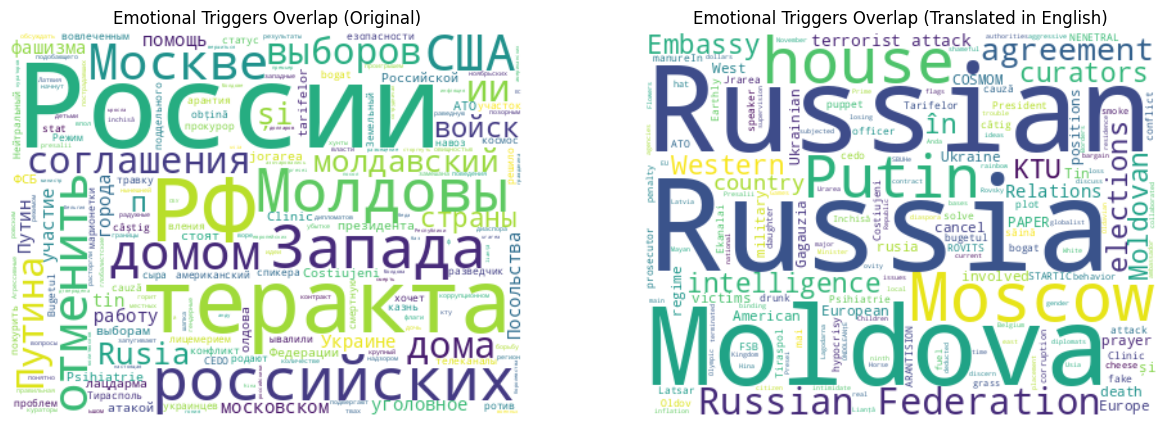

In [128]:
stopwords = stopwordsiso.stopwords('ro').union(stopwordsiso.stopwords('ru'))
wordcloud_original = WordCloud(width=400, height=300, background_color='white',
                               stopwords=stopwords).generate(text_overlap)
wordcloud_translated = WordCloud(width=400, height=300, background_color='white',
                                 stopwords=stopwordsiso.stopwords('en')).generate(text_overlap_translated)

# Plotting the word clouds
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Display the word clouds
axs[0].imshow(wordcloud_original, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Emotional Triggers Overlap (Original)')

axs[1].imshow(wordcloud_translated, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Emotional Triggers Overlap (Translated in English)')

plt.savefig('wordcloud.png')
plt.show()

______________________